In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

In [3]:
"""STEP-1: read the image and get samples/training data for each category"""

# Define training areas (ROIs) and extract training data (as pandas-"data frames").
def open_image_extract_training_sets():
    # 1. Open the image and convert it to an array
    im = np.array(Image.open('spot.jpeg'))      # im = [height, width, num_of_bands] ([371,781, 3]) 
    # Cut sample area (roi) for each category, and generate input data sets for training.
    # 1.water sample 
    roi = im[150:225, 180:245, 0:3] # 24 x 15 x 3
    pixels = np.concatenate(roi, axis=0) 
    df1 = pd.DataFrame({'1-Red':pixels[:,0], '2-Green':pixels[:,1], '3-Blue':pixels[:,2], '4-Class':'water'})
    # 2.forest sample 
    roi = im[15:114, 34:129, 0:3] 
    pixels = np.concatenate(roi, axis=0)
    df2 = pd.DataFrame({'1-Red':pixels[:,0], '2-Green':pixels[:,1], '3-Blue':pixels[:,2], '4-Class':'forest'})
    # 3.bareland sample 
    roi = im[214:260, 235:274, 0:3] 
    pixels = np.concatenate(roi, axis=0)
    df3 = pd.DataFrame({'1-Red':pixels[:,0], '2-Green':pixels[:,1], '3-Blue':pixels[:,2], '4-Class':'developedland'})
    # concatenate all samples, so that generate a single data set.
    df = pd.concat([df1, df2, df3]) 
    # try to save the traning data in Csvformat.
    #path = "sampleData.csv"
    #df.to_csv(path) 
    df.to_csv('satimg.csv')
    #data = pd.read_csv('satimg.csv')
    #data.shape
    # divide the sample data into two parts.
    # 1) sets of inputs: R G B
    rgb = df[df.columns[0:3]].values 
    # 2) desired outputs (lables/land cover types above).
    labels= df[df.columns[3]] 
    # 3) one-hot encoding: transforms the desired outputs into a new format/vector of "1's" and "0's". 
    # As a result, the desired output is the "hot" (i.e., "1") and while the rest are "0".
    # i.e., "water" =>>    [1, 0, 0, 0, 0, 0, 0]; 
    #        "forest" =>      [0, 1, 0, 0, 0, 0, 0]; 
    #        "bareland" => [0, 0, 1, 0, 0, 0, 0]; 
    encoder = LabelEncoder()     # create the encoder object.
    encoder.fit(labels)
    labels = encoder.transform(labels)
    total_labels = len(labels)     # total number of the labels inputs.
    unique_labels = len(np.unique(labels))     # unique number of the labels (desired outputs).
    one_hot = np.zeros((total_labels, unique_labels))    # one-hot encoding matrix (zeros).
    one_hot[np.arange(total_labels), labels] = 1    # set "1" and generate unique vector for each unique output.

    # returns a pair of input data sets: "rgb values" and "desired outputs".
    return (rgb, one_hot)


# 1) RGB represents "sets of inputs".
# 2) L represents crossponding desired output(s) for each input data.
RGB, L = open_image_extract_training_sets() 
RGB, L = shuffle(RGB, L, random_state=300) 
# print(RGB.shape, L.shape)

In [4]:
""" STEP-2: define some hyperparameters """

LEARN_RATE = 0.03
TRAIN_EPOCHS = 200 
n_rgb = RGB.shape[1]    # number of columns/parameters, i.e., R, G, B.

# Define the number of hidden layers and number of neorons/nodes for each layer.
node_hidden_1 = 256
node_hidden_2 = 256
node_hidden_3 = 128
node_hidden_4 = 64
node_output = 3     # number of land cover types, i.e., water, forest, crops...

# saver path of the trained neural network.
save_path = "Satellite_Image_Classification_NN_Training_Part" 

# define a container to hold accuracy history/changes.
accuracy_hist = []


In [5]:
""" STEP-3: variables and place holders for the training process """

# Y = X*W + b
X = tf.placeholder(tf.float32, [None, n_rgb]) 
W = tf.Variable(tf.zeros([n_rgb, node_output]), name = 'Weights') 
b = tf.Variable(tf.zeros(node_output), name = 'Biases') 
Y_= tf.placeholder(tf.float32, [None, node_output]) 

# define the weights and baises dictionaries for each hidden layer.
# 1) W(ih) = new Matrix[rows, cols] = [num_input_node, num_hidden_node].
# ...
# 5) W(out) = new Matrix[rows, cols] = [num_hidden_node,num_out_node].
weights = {
                    'h1': tf.Variable(tf.truncated_normal([n_rgb, node_hidden_1])), 
                    'h2': tf.Variable(tf.truncated_normal([node_hidden_1, node_hidden_2])), 
                    'h3': tf.Variable(tf.truncated_normal([node_hidden_2, node_hidden_3])), 
                    'h4': tf.Variable(tf.truncated_normal([node_hidden_3, node_hidden_4])), 
                    'out': tf.Variable(tf.truncated_normal([node_hidden_4, node_output]))
}

biases = {
                  'b1': tf.Variable(tf.truncated_normal([node_hidden_1])),
                  'b2': tf.Variable(tf.truncated_normal([node_hidden_2])),
                  'b3': tf.Variable(tf.truncated_normal([node_hidden_3])),
                  'b4': tf.Variable(tf.truncated_normal([node_hidden_4])),
                  'out': tf.Variable(tf.truncated_normal([node_output]))
}

In [6]:
"""STEP-4: create the neural network/model with sigmoid activation function:
( f(x) = 1 / (1 + exp(-x)) ); You may use other activation function as well.""" 

def multilayer_network(x, weights, biases):          # Y = XW + b

    sum_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) # summation function Y = X*W + b.
    layer_1 = tf.nn.sigmoid(sum_1)    # activation or transfer function. 
    sum_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.sigmoid(sum_2) 
    sum_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
    layer_3 = tf.nn.sigmoid(sum_3) 
    sum_4 = tf.add(tf.matmul(layer_3, weights['h4']), biases['b4'])
    layer_4 = tf.nn.sigmoid(sum_4)
    # Output layer
    out_layer = tf.matmul(layer_4, weights['out']) + biases['out']
    return out_layer

In [7]:
"""STEP-5: init the variables, call the network, and define loss, loss_funcs and training step """

# init all variables, saver and call the model.
init = tf.global_variables_initializer()
saver = tf.train.Saver()

# call the define neural network/model( Y = X*W + b).
Y = multilayer_network(X, weights, biases) # Predicted values per input parameters.

# loss, lost function and optimizer, so that minimize the loss.
# Y: predicted values.
# Y_: desired output values. 
y_hat_softmax = tf.nn.softmax(Y)
total_loss = tf.reduce_mean(-tf.reduce_sum(Y_ * tf.log(y_hat_softmax), [1]))
#loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=Y, labels=Y_)
#loss_func = tf.reduce_mean(loss) 
train_network = tf.train.GradientDescentOptimizer(LEARN_RATE).minimize(total_loss)

In [8]:
"""STEP-6: create a session, run the process and train the network"""
    # create a session
sess = tf.Session()
sess.run(init)
    # training epoch: an epoch stands for one forward and one backward pass of available
    # training examples in a Neural Network(NN). 
    # feed_dict = "training set"; this is a supervised learning. In supervised learning, each
    # training set is a pair that consists of an input and output (the desired output crossponds
    # to the input). Here, X is input and Y_ is the desired output for this input X.
for epoch in range(TRAIN_EPOCHS):

    # training
    sess.run(train_network, feed_dict = {X: RGB, Y_: L}) 
    # accuracy 
    correct_prediction=tf.equal(tf.argmax(Y, 1), tf.argmax(Y_,1))
    accuracy= tf.reduce_mean(tf.cast(correct_prediction, tf.float64))
    accuracy = sess.run(accuracy, feed_dict = {X:RGB, Y_: L})
    accuracy_hist.append(accuracy)

    if epoch == 0:
            print('Epoch ', 'Training Accuracy ')
            print('---------|------------------------------')
    if epoch % 50 == 0:
           print('{:5d}'.format(epoch), '{:16f}'.format(np.round(accuracy,5)))

Epoch  Training Accuracy 
---------|------------------------------
    0         0.625360
   50         0.722220
  100         0.723720
  150         0.725830


In [9]:
"""STEP-7: Save the trained Neural Network"""

save_path = saver.save(sess, save_path)

"""Optional """
print('Model saved as: %s', save_path)
print('*---The training is completed---')


Model saved as: %s Satellite_Image_Classification_NN_Training_Part
*---The training is completed---


Text(0,0.5,'Accuracy')

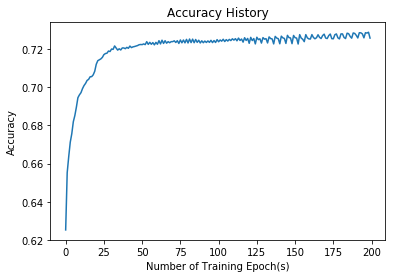

In [10]:
"""STEP-8: plot accuracy history for a reference"""

plt.plot(accuracy_hist)
plt.title('Accuracy History')
plt.xlabel('Number of Training Epoch(s)')
plt.ylabel('Accuracy')




In [11]:
"""Step-9, restore saved neural network"""
saved_path = "Satellite_Image_Classification_NN_Training_Part"  # saved path in your PC
res_sess = tf.Session()
saver = tf.train.import_meta_graph('Satellite_Image_Classification_NN_Training_Part.meta')
saver.restore(res_sess, saved_path)

Prediction = tf.argmax(Y, 1)

INFO:tensorflow:Restoring parameters from Satellite_Image_Classification_NN_Training_Part


Text(0.5,1,'Classified Image')

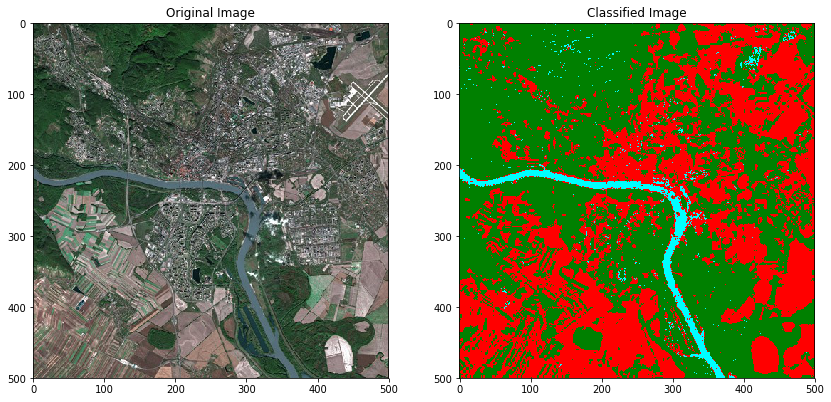

In [14]:
"""Step-10, Validate the restored neural network"""
from matplotlib import colors


#Open an image (input data)
im = np.array(Image.open('spot.jpeg'))   # example input image in your PC
size = im.shape

# define output array for the classified image/result
output = np.zeros(size[0] * size[1], dtype='float32').reshape(size[0], size[1])

# loop through the whole image
for y in range(size[0]):
      for x in range(size[1]):
            x_vec = im[y, x, 0: size[2]]  # since we have three bands (RGB)
            prediction_run = res_sess.run(Prediction, feed_dict = {X: [x_vec]})  # get the prediction
            output[y,x] = prediction_run[0]  # get the index of the maximum value

#Create a color map
myCmap = colors.ListedColormap([ 'cyan','green', 'red'])

# display the original image and classified image/result
fig, ax = plt.subplots(1, 2, figsize = (14, 12))
ax[0].imshow(im)
ax[0].set_title('Original Image')

# display the classified image/result
ax[1].imshow(output, myCmap)
ax[1].set_title('Classified Image')

Text(0.5,1,'Classified2 Image')

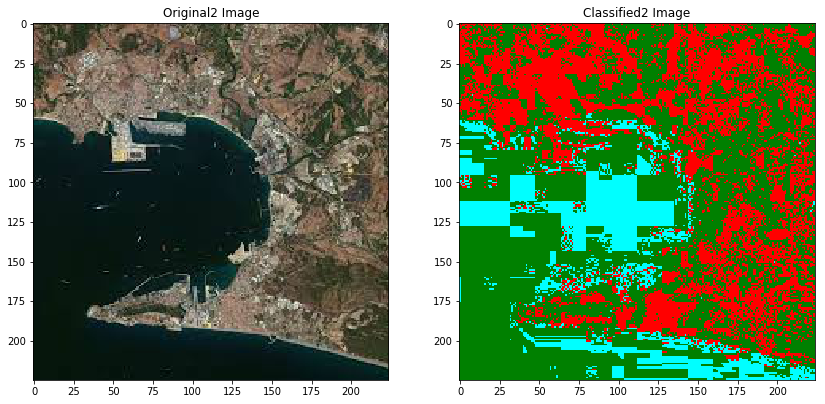

In [27]:
#Open an image (input data)
im = np.array(Image.open('spot2.jpg'))   # example input image in your PC
size = im.shape

# define output array for the classified image/result
output = np.zeros(size[0] * size[1], dtype='float32').reshape(size[0], size[1])

# loop through the whole image
for y in range(size[0]):
      for x in range(size[1]):
            x_vec = im[y, x, 0: size[2]]  # since we have three bands (RGB)
            prediction_run = res_sess.run(Prediction, feed_dict = {X: [x_vec]})  # get the prediction
            output[y,x] = prediction_run[0]  # get the index of the maximum value

#Create a color map
myCmap = colors.ListedColormap([ 'cyan','green', 'red'])

# display the original image and classified image/result
fig, ax = plt.subplots(1, 2, figsize = (14, 12))
ax[0].imshow(im)
ax[0].set_title('Original2 Image')


# display the classified image/result
ax[1].imshow(output, myCmap)
ax[1].set_title('Classified2 Image')
